In [47]:
#! pipreqs --encoding=utf-8 c:/Users/Diya/Documents/GItHub/DELTA_Element3

In [58]:
# Use python 3.11.9

## CONTENTS

- **0. Import Libraries**

- **1. Data Preprocessing**
  - 1.1. Importing and understanding the data
  - 1.2. A note on handling Class Imbalance

- **2. Benchmark: vaderSentiment Dictionary**
  - 2.1. Clean the tweets for VaderSentiment
  - 2.2. Fit the VaderSentiment on cleaned tweets in test data
  - 2.3. Generate report for VaderSentiment

- **3. RNN**
  - 3.1. Clean the tweets for training the embeddings
  - 3.2. Training the FastText embeddings
  - 3.3. Building and Training the RNN model
  - 3.4. Classification report for RNN
  - 3.5. Hyperparameter tuning

- **4. DistilBERT**
  - 4.1. Clean the tweets for DistilBERT
  - 4.2. Predict with pre-trained and fine-tuned DistilBERT
  - 4.3. Classification report for pre-trained DistilBERT
  - 4.4. Classification report for fine-tuned DistilBERT

- **5. Final Comparison**
  - 5.1. Code (can be ignored)
  - 5.2. Comparison Table and conclusion


____________________________________________________

## 0. Import Libraries 

In [57]:
# For preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from Data_Preprocess import DataPreprocessor

from Classification_Scores import ClassificationEvaluator

from Data_Augmentation import DataAugmentor

from DistilBERT import DistilBERTSentimentAnalyzer, run_pretrained_analysis, run_finetuned_analysis

# For VaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# For RNN model 
import nltk
from nltk.tokenize import word_tokenize
from gensim.models import FastText
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.metrics import AUC, Precision, Recall
from keras_tuner import BayesianOptimization

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Diya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Diya\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Diya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

The **DataPreprocessor** class imported from **Data_Preprocess.py** is an all in one class with methods required for processing the raw tweets before feeding them to any model. Methods are defined individually to foster flexibility, allowing customization of data perprocessing steps per the requirement of specific model. At the same time, improves both, redability of the code and understandability of the underlying actions.

Below is the description of each method briefing its logic and reason.

1. **remove_spam_content( )**<br>
Tweets that are highly similar in their content (similarity>80%>) are removed. Bots often generate repeated content. I went through filtered out tweets and noticed that almost all of them were irrlevent to bitcoin and crypto.

2. **remove_hashtags( )**<br> 
Initially, I removed all hashtags from tweets, but later realized that complete removal is inappropriate as it causes relevant data loss. *This method retains top 30 most frequent hashtags as all of them are related to bitcoin and crypto. Noticed significant improvement in classification after its implementation.*

3. **remove_link( )**<br>
Removes link(s) from the tweet, if any.

4. **remove_whitespace_html( )**<br>
Removes all the whitespace and HTML tags from the tweet.

5. **remove_emojis( )**<br>
Similar t hashtahs, but *only expression and emotion related emojis are retained while all others removed. The retained emojis are then demojized as the add sentiment to the tweet.*

6. **clean( )**<br>
This method removes punctuations and stop words and applies lemmatization. *It's worth to note that a significant performance improvement is observed when numbers and '$' character is retained in the tweet. This makes sense as the tweets are relaed to bitcoin and many of them have its price mentioned.*


The **ClassificationEvaluator** class imported from **Classification_Scores.py** is to evaluate the performance of a classification model particularly focusing on how well it handles imbalanced classes. It has methods defined are to print classification report, plot confusion matrix, ROC-AUC Curve and Precision-Recall curve.

1. **evaluate( )**<br>
Prints the classification report with precision, recall, and F1-score for each class, along with overall accuracy.

2. **plot_confusion_matrix( )**<br>
Plots a confusion matrix heatmap showing the count of true positive, true negative, false positive, and false negative predictions.

3. **plot_roc_auc( )<br>**
Plots the ROC curve and calculates the area under the curve (AUC). Helps to understand the trade-off between true positive rate (recall) and false positive rate (1-specificity) for different threshold settings.

4. **plot_precision_recall_auc( )<br>**
First of all, flips the labels to consider minority class for plotting. Calculates and plots the precision-recall curve for the minority class (negative class) and calculates the area under this curve (PR AUC).

The **DataAugmentor** class imported from **Data_Augmentation.py** has the method 'augment_data' defined that takes the dataframe, and the number of samples as the argument, performs the augmentation of the minority class and returns the dataframe. It's implemented to tackle the problem of call imbalance.

Note: Since data augmentation is computationally expensive, I worked it out in colab and saved the augmented dataset in the directory with the name 'augmented train data.csv'. From there I imported it directly in the notebook to run the train experiments on RNN and fine tuned DistilBERT.

More on data augmentation and class imbalance at the end of the section 1.Data Preprocessing.

## 1. Data Preprocessing

### 1.1. Importing and understanding the data.

In [3]:
# Importing the train and test datasets
train_df = pd.read_parquet('btc_tweets_train.parquet.gzip').reset_index()
test_df = pd.read_parquet('btc_tweets_test.parquet.gzip').reset_index()

In [4]:
# Running a few checks to understand the datasets (shape, empty tweets, info and head)
def df_info(df):
    print(f'shape of the datafreme: {df.shape}')
    print(f'Number of empty values: {df.isnull().sum().sum()}')
    print(df.info())
    print(df.head())

In [5]:
df_info(train_df)

shape of the datafreme: (1500, 6)
Number of empty values: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet ID          1500 non-null   int64 
 1   hashtags          1500 non-null   object
 2   content           1500 non-null   object
 3   username          1500 non-null   object
 4   user_displayname  1500 non-null   object
 5   sentiment         1500 non-null   bool  
dtypes: bool(1), int64(1), object(4)
memory usage: 60.2+ KB
None
              tweet ID                                           hashtags  \
0  1641579121972236290  [Bitcoin, Bitcoin, BTC, Bitcoin, BTC, SHIB, HO...   
1  1641579176171016194                 [Bitcoin, bitcoinordinals, crypto]   
2  1641579486071390208  [BTC, SHIB, HOGE, SAITAMA, BNB, DOGE, ETH, Bab...   
3  1641579537103302656                                              [BTC]   
4  1641579588399

In [6]:
df_info(test_df)

shape of the datafreme: (500, 6)
Number of empty values: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet ID          500 non-null    int64 
 1   hashtags          500 non-null    object
 2   content           500 non-null    object
 3   username          500 non-null    object
 4   user_displayname  500 non-null    object
 5   sentiment         500 non-null    bool  
dtypes: bool(1), int64(1), object(4)
memory usage: 20.1+ KB
None
              tweet ID                                           hashtags  \
0  1641861708246552576                                      [crypto, btc]   
1  1641861783898972167                                 [Bitcoin, Bitcoin]   
2  1641862152532418562  [Giveaway, BTC, SolanaGiveaways, Giveaway, Air...   
3  1641862338369183753  [EOS, USDT, BTC, crypto, Bitcoin, etherium, Bi...   
4  1641862430434131

In [7]:
# Dropping the unnecessary features.
# Note: Although 'hashtags' feature is removed, hashtags in the tweets are differently handled in DataPreprocess class
train_df = train_df.drop(['tweet ID', 'user_displayname', 'hashtags'], axis=1)
test_df = test_df.drop(['tweet ID', 'user_displayname', 'hashtags'], axis=1)

In [8]:
# Converting the sentiment labels from bool to int
train_df['sentiment'] = train_df['sentiment'].astype(int)
test_df['sentiment'] = test_df['sentiment'].astype(int)

### 1.2. A note on handling Class Imbalance

Far as I have understood the dataset and this task, 'Call Imbalance' is the problem of utmost importance that's having significant influence on right from data preprocessing to performance evaluation and fine tuning. From all the available strategieg, below are a few that I found suiting the characteristics of our dataset and followed them to pacify the impact of class imbalance

1. **Using different Metrics**<br>
Accuracy is not the best metric in the presence of class imbalance. Hence throughout the notebook, considered other metrics like precision, recall, f1-score, ROC_AUC curve and PR curve.

2. **Resampling Techniques**<br>
- **Undersampling**: not preferred since the dataset is small and undersampling will result in loss of important information.
- **Oversampling**: In this I particularly followed 2 approaches:-<br>
**SMOTE** was rejected since it performs best with numerical data. I still vectorized the text and tested it, but the results were not impressive. Both recall and precision for minority (negative) class worsened.<br>
**Data Augmentation** I used a pre-trained 'bert-base-uncased' model to generate additioanl 1000 minority class examples from the existing (270approx) samples. Trained RNN model with the 'augmented train df.csv' and below is its classification report and confusion matrix. Precision and Recall even after data augmentation is well below 50% although AUC shuowed slight improvement from 0.59 to 0.61. I think the reason is extremly limited number of minority samples to regenerate from. Hence the regenerated samples significantly lacked variation needed to train the model. <br>
![alt text](<augmented df classification perf.png>)
![alt text](<augmented df confusion matrix.png>)

3. **Using Class Weights**
Assigned higher weight to minority class so that the model pays more attention to them while training. Good starting point is the multiple of minority class such that 'minority class samples x multiple = majority class samples'. This is the most convenent way that yielded promising results.

**Colclusion:** With different in place, use of class weights was the most effective in improving the classification metrics for the negative class. Also it is the most convenient and flexible way to work with. I have followed this approach to help training with an imbalanced dataset.

In the cell below is the code to perform data augmentation. However, since it was not giving any improved results, I havent used the augmented dataset for training. The code only sits to demonstrate the implementation. A copy of augmented data sits in the folder for review, if needed.

In [21]:
# # Clean the tweets to get cleaned augmented tweets
# augmenter_data_preprocess = DataPreprocessor(df=train_df, content_column='content')
# augmented_train_df = augmenter_data_preprocess.preprocess(remove_spam=True, remove_link=True, remove_hashtags=True, remove_whitespace_html=True,remove_emoji=True)

# # To augment the dataset
# augmenter = DataAugmentor()
# augmented_train_df = augmenter.augment_data(df=augmented_train_df)
# augmented_train_df.to_csv('augmented train data.csv')

## 2. Benchmark: vaderSentiment Dictionary

For sentiment analysis using VADER, it's best to apply VADER to the raw, uncleaned text to leverage its strengths in handling informal language, punctuation, and emojis. However, when it comes to Links, it is best to remove them. Links are irrelevent to the sentiment and could add unnecessary noise, potentially influencing the sentiment. Also after multiple iterations, it was obseved that most of the emojis were adding no value but the noise. Hence only expression specific emojis are retained and ret all are removed. 

The preprocessing pipeline for vaderSentiment
- Clean the tweets
- Then apply vader sentiment dictionary on the cleaned tweets
- Initialize the vaderSentiment analyzer
- Apply it on the cleaned tweets and get the compound scores
- Set the threshold to transform the compound scores to positive class (1) or negative class (0)
- Generate classification report

### 2.1. Clean the tweets for VaderSentiment

In [9]:
vader_test_df = test_df.copy()

# Initialize the DataPreprocessor class for vaderSentiment
vader_test_datapreprocessor = DataPreprocessor(df=test_df, content_column='content')

In [10]:
# Getting the tweets ready by removing spam, unnecessary hashtags, links, whitespace, HTML tags and emojis
vader_test_df = vader_test_datapreprocessor.preprocess( remove_spam=True,
                                                        remove_hashtags=True, 
                                                        remove_link=True, 
                                                        remove_whitespace_html=True, 
                                                        remove_emoji=True )

c:\Users\Diya\Documents\GItHub\DELTA_Element3\Data_Preprocess.py:114: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  tweet = BeautifulSoup(tweet, 'html.parser').get_text()


In [11]:
vader_test_df.head()

,content,username,sentiment,cleaned_content
0,#crypto $crypto #btc \nI am Chinese crypto alp...,huahuayjy,1,#crypto $crypto #btc I am Chinese crypto alpha...
1,#Bitcoin would have to fall another 80% to rea...,luke_broyles,0,#Bitcoin would have to fall another 80% to rea...
2,#Giveaway $1000 Matic in 3Days\n\n🏆To win\n1️⃣...,cryptomarsdo,1,#Giveaway $1000 Matic in 3Days To win keycap_...
3,Up or Down?\n\n!!! $EOS #EOS !!!\n\nVS\n\n$USD...,andreyukrnet,1,Up or Down? !!! $EOS !!! VS $USDT #USDT AND $B...
4,Mid Day Mix-up is LIVE! Never know who might s...,JustAman04,1,Mid Day Mix-up is LIVE! Never know who might s...


In [12]:
# look over an example to see if the tweets are cleaned as expected
index = 43
vader_test_df['content'].iloc[index], vader_test_df['cleaned_content'].iloc[index], vader_test_df['sentiment'][index]

('🚨BREAKING NEWS🚨\n\nTron founder Justin Sun ( @justinsuntron ) makes a bold move and offers to purchase ALL 41,500 #Bitcoin from the US Government at a 10% discount! 💸\n\n💰 Is this the deal of the century? \n\nStay tuned to find out!\n\n#Crypto #BTC #Investment #USA #Tron #Bitcoin… https://t.co/F39PWK76xR',
 'BREAKING NEWS Tron founder Justin Sun ( @justinsuntron ) makes a bold move and offers to purchase ALL 41,500 #Bitcoin from the US Government at a 10% discount!   Is this the deal of the century? Stay tuned to find out! #Crypto #BTC #Bitcoin…',
 1)

### 2.2. Fit the VaderSentiment on cleaned tweets in test data

In [13]:
# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to apply VADER sentiment analysis and get the compound score
def get_sentiment_score(text):
    sentiment_dict = analyzer.polarity_scores(text)
    return sentiment_dict['compound']  # 'compound' score is a normalized score between -1 (negative) and +1 (positive)

# Apply sentiment analysis to the 'content' column and create a new column for the sentiment score
vader_test_df['vader_sentiment'] = vader_test_df['cleaned_content'].apply(get_sentiment_score)

# Classify the sentiment based on the compound score.
# Threshold of -0.05 results in the best classification performance
def classify_sentiment(score):
    if score >= -0.05:
        return True
    else:
        return False

# Apply the classification and create a new column for the sentiment label
vader_test_df['vader_sentiment_label'] = vader_test_df['vader_sentiment'].apply(classify_sentiment).astype(int)


In [14]:
vader_test_df.head()

,content,username,sentiment,cleaned_content,vader_sentiment,vader_sentiment_label
0,#crypto $crypto #btc \nI am Chinese crypto alp...,huahuayjy,1,#crypto $crypto #btc I am Chinese crypto alpha...,0.4835,1
1,#Bitcoin would have to fall another 80% to rea...,luke_broyles,0,#Bitcoin would have to fall another 80% to rea...,-0.8519,0
2,#Giveaway $1000 Matic in 3Days\n\n🏆To win\n1️⃣...,cryptomarsdo,1,#Giveaway $1000 Matic in 3Days To win keycap_...,0.8555,1
3,Up or Down?\n\n!!! $EOS #EOS !!!\n\nVS\n\n$USD...,andreyukrnet,1,Up or Down? !!! $EOS !!! VS $USDT #USDT AND $B...,0.0000,1
4,Mid Day Mix-up is LIVE! Never know who might s...,JustAman04,1,Mid Day Mix-up is LIVE! Never know who might s...,-0.4184,0


### 2.3. Classification report for vaderSentiment

Classification report:

              precision    recall  f1-score   support

           0       0.58      0.45      0.51        96
           1       0.87      0.92      0.89       387

    accuracy                           0.83       483
   macro avg       0.73      0.68      0.70       483
weighted avg       0.81      0.83      0.82       483



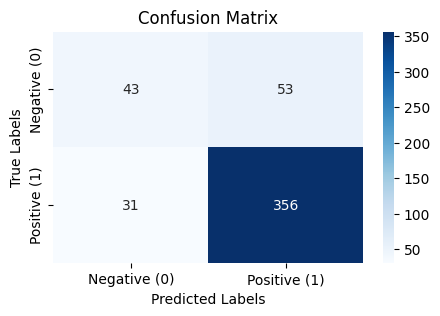

In [15]:
# Initializing the classification performance evaluator class for vader
vader_performance_evaluator = ClassificationEvaluator(true_labels = vader_test_df['sentiment'], 
                                                      predicted_labels = vader_test_df['vader_sentiment_label'])

vader_performance_evaluator.evaluate()
vader_performance_evaluator.plot_confusion_matrix()


#### vaderSentiment Classification Report Interpretation

- VaderSentiment is better off in identifying positive sentiments.
- Recall 92% indicates model captures most of the positive tweets.
- This is expected anyways, since the dataset is imbalanced.

## 3. RNN 

### 3.1. Clean the tweets for training the embeddings

In [16]:
# Initialize the DataPreprocessor class for DistilBERT
rnn_train_datapreprocessor = DataPreprocessor(df=train_df, content_column='content')
rnn_test_datapreprocessor = DataPreprocessor(df=test_df, content_column='content')

In [17]:
# tweets in both, train and test datsasets are cleaned
rnn_train_df = rnn_train_datapreprocessor.preprocess(remove_spam=True, 
                                                     remove_hashtags=True, 
                                                     remove_link=True, 
                                                     remove_whitespace_html=True, 
                                                     remove_emoji=True, 
                                                     clean_text=True)

rnn_test_df = rnn_test_datapreprocessor.preprocess(remove_spam=True, 
                                                   remove_hashtags=True, 
                                                   remove_link=True, 
                                                   remove_whitespace_html=True, 
                                                   remove_emoji=True, 
                                                   clean_text=True)

c:\Users\Diya\Documents\GItHub\DELTA_Element3\Data_Preprocess.py:114: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  tweet = BeautifulSoup(tweet, 'html.parser').get_text()
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Diya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Users\Diya\Documents\GItHub\DELTA_Element3\Data_Preprocess.py:114: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  tweet = BeautifulSoup(tweet, 'html.parser').get_text()
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Diya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
# Exmple to check if cleaning is successful
i = 43
rnn_train_df['content'][i], rnn_train_df['cleaned_content'][i], rnn_train_df['sentiment'][i]

('came back home to the @PepesPixel \n\n#BTC #Ordinals https://t.co/Ks8JyoL4zV',
 'came back home to the pepespixel btc ordinal',
 1)

In [19]:
rnn_train_df.head()

,content,username,sentiment,cleaned_content
0,"$Bitcoin TO $100,000 SOONER THAN YOU THINK‼️💯🙏...",BezosCrypto,1,$ bitcoin to $ 100000 sooner than you think bi...
1,Alright I have my rares. Who else is grabbing ...,spartantc81,1,alright i have my rares who else is grabbing s...
2,"Bitcoin (BTC) Targets Over $100,000 as This Im...",BezosCrypto,1,bitcoin btc target over $ 100000 a this import...
3,📢 Xverse Web-based pool is live:\n\n•Update @x...,godfred_xcuz,1,xverse webbased pool is live update xverseapp ...
4,"Yesterday, a Bitcoin projection was displayed ...",goddess81oo,1,yesterday a bitcoin projection wa displayed on...


### 3.2. Training the FastText embeddings

#### Parameter selection in the FastText training

Monitored model performance changing the following parameters and finally selected those, that RNN performed best with.

- vector_size=50:  Dimensionality of the word vectors (embeddings) that the model wil learn. RNN model performed best with the size of 50.

- window=5: Model will look at the 5 words before and after the target word in a sentence during training.

- min_count=1:Any word that appearing even once in the corpus will be included in the vocabulary. Set to 1 since the dataset is small.

- sg=0: 0 means that the model will use the Continuous Bag of Words (CBOW) algorithm, where the context (surrounding words) predicts the target word.<br>
If sg=1, the model will use the Skip-gram algorithm, where the target word predivts the context.

In [21]:
# Tokenize the cleaned tweets (split by spaces)
tokenized_tweets = [tweet.split() for tweet in rnn_train_df['cleaned_content']]

# Train FastText model using Gensim's implementation
fasttext_model = FastText(sentences=tokenized_tweets, vector_size=50, window=5, min_count=1, sg=0, epochs=10)

In [22]:
# Example: Get vector for a word 
print(f"Vector for 'bitcoin': {fasttext_model.wv['bitcoin']}")

# Example: Get most similar words
print(f"Words similar to 'bitcoin': {fasttext_model.wv.most_similar('bitcoin')}")

Vector for 'bitcoin': [-8.6953783e-01  2.1090146e-02  1.0496285e+00 -2.0635866e-01
 -6.2093300e-01  1.7846389e-01 -1.2667803e+00  1.3184445e+00
 -5.2661943e-01  8.6281210e-01  8.1262904e-01 -3.4848225e-01
  7.8967792e-01 -3.8299635e-01 -5.4301906e-01  1.3944496e+00
  9.7562557e-01 -8.7815052e-01 -8.8862985e-01 -9.0379488e-01
 -4.3266378e-02  3.6643767e-01  4.2109713e-01  6.0068083e-01
  2.3107678e-01  5.3038031e-01 -1.1081201e+00 -2.0109907e-01
 -1.2592362e+00  3.7833118e-01  2.1937406e+00  6.1505270e-01
 -7.1469575e-01  1.7469046e+00 -9.8060742e-02  4.7011176e-01
 -2.3498891e-01  4.9605548e-01  2.5337466e-04  8.0533326e-02
  4.1228658e-01  9.7027481e-01 -1.2576091e-01  1.2138741e+00
  9.4140399e-01 -1.8388922e+00  9.9145508e-01 -3.3066127e-01
 -1.8777192e-01  1.4076610e+00]
Words similar to 'bitcoin': [('swanbitcoin', 0.9999940395355225), ('bitcoinfrogs', 0.9999939203262329), ('bitcoinbaytpa', 0.9999923706054688), ('bitcoinwith', 0.9999921917915344), ('bitcoinlivedb', 0.99999189376831

### 3.3. Building and Training the RNN model

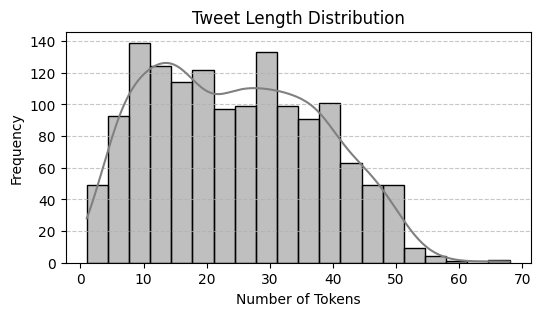

In [59]:
# Tweet length plot to decide on sequence length.
tweets = rnn_train_df['cleaned_content'].to_list()

# Tokenize each tweet to calculate its length
tweet_lengths = [len(word_tokenize(tweet)) for tweet in tweets]

# Plot for the tweet length distribution
plt.figure(figsize=(6, 3))
sns.histplot(tweet_lengths, bins=20, kde=True, color='grey')
plt.title('Tweet Length Distribution')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Sequence length of 50 farly covers all the tweets.

In [24]:
# Parameters
max_sequence_length = 50
embedding_dim = 50
embedding_matrix = fasttext_model.wv.vectors # embedding matrix to be passed as trained weights in the RNN embedding layer
vocab_size = len(fasttext_model.wv)

In [25]:
# Tokenize the tweets
tokenizer = Tokenizer(num_words=vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(rnn_train_df['cleaned_content'])

# sequences are tweets transformed into arrays where each word is sequentially replaced by a number which corresponds to the index of that word in the vocabulary
train_sequences = tokenizer.texts_to_sequences(rnn_train_df['cleaned_content']) 
padded_train_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post')

test_sequences = tokenizer.texts_to_sequences(rnn_test_df['cleaned_content'])
padded_test_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post')

In [26]:
# An example look over
padded_test_sequences[89]

array([   1,  414,  240,  511,    4, 1471,  232,   16,  440,  137, 5816,
        142,  101,    4,  314,  142,  262, 5163,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0])

In [27]:
# Dimension check
padded_train_sequences.shape, rnn_train_df['sentiment'].shape

((1438, 50), (1438,))

In [28]:
# Split the data to training and validation
X_train, X_val, y_train, y_val = train_test_split(padded_train_sequences, rnn_train_df['sentiment'], test_size = 0.2, random_state = 9)
# Changing the dtype from series to array
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()

# Preparing the test data
rnn_X_test = padded_test_sequences
rnn_y_test = rnn_test_df['sentiment'].to_numpy()

- Class weights are calculated to instruct model to pay more attention to the minority class. Model performs fairly same when the weight for class 0 is incrementally changed from 2.6 to 3.1 after which it over predicts minority class imparing the model performance on majority class. 
- It is finally dictated by the classification objective to decide on which class is more important. The weights will be ajusted accordingly. In this notebook, weights with which model performs the best on both the classes are retained.

In [29]:
# Calculate the class weights to handle imbalance
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 2.625570776255708, 1: 0.6176154672395274}

#### RNN Model Structure and Features:

1. Input Layer <br>
The model expects sequences of a specific length (max_sequence_length). This length corresponds to the number of tokens in each tweet i.e. text sequence.

2. Embedding Layer<br>
Vocabulary Size (vocab_size): The total number of unique tokens.<br>
Embedding Dimension (embd_dim): Each word or token is represented as a vector of this length. Captures semantic information.<br>
Pretrained Weights (embedding_matrix): The embeddings are initialized with pretrained weights, such as those from FastText. By setting trainable=False, you ensure these embeddings are not updated during training, preserving the pretrained semantic knowledge.
RNN Layer:

3. RNN Type (LSTM or GRU)<br> 
The model allows for flexibility in choosing between Long Short-Term Memory (LSTM) or Gated Recurrent Unit (GRU). 
LSTM is preferred for handling long sequences, while GRU is faster and has fewer parameters.
Units (64): The dimensionality of the output space for the RNN layer.
Kernel Regularizer (l2(0.02)): Adds a penalty on the weights to prevent overfitting. Encourages the model to learn simpler patterns.
Bidirectional Option:

4. Bidirectional Layer (bidirectional=True/False)<br>
If True, wraps the RNN layer in a Bidirectional wrapper, allowing the model to learn from the sequence in both forward and backward directions.
Enhancinces the model's understanding of context.

5. Dropout Layer<br>
Dropout (0.2): Randomly sets 20% of the inputs to zero during training to prevent overfitting. Makes the model more robust.

6. Output Layer<br>
Dense Layer: A single unit with a sigmoid activation function suitable for binary classification tasks. Outputs probability for binary classification.

In [30]:
# Build the RNN model
def build_rnn_model(embd_dim, rnn_type='LSTM', bidirectional=False):
    model = Sequential()
    model.add(Input(shape=(max_sequence_length,)))
    model.add(Embedding(input_dim = vocab_size, 
                        output_dim = embd_dim, 
                        weights=[embedding_matrix],  
                        trainable=False))
    
    if rnn_type == 'LSTM':
        rnn_layer = LSTM(units = 64, return_sequences = False, kernel_regularizer=l2(0.02))
    elif rnn_type == 'GRU':
        rnn_layer = GRU(units = 64, return_sequences= False, kernel_regularizer=l2(0.02))
        
    if bidirectional:
        model.add(Bidirectional(rnn_layer))
    else:
        model.add(rnn_layer)
        
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'sigmoid', kernel_regularizer=l2(0.02)))
    
    model.compile(optimizer=Adam(learning_rate=0.000196), loss='binary_crossentropy', metrics=['accuracy']) #, ['accuracy'], Precision(), , AUC(), Recall())
    return model

In [31]:
# Initialize the model
model = build_rnn_model(embd_dim=embedding_dim, rnn_type='LSTM', bidirectional=False)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 50)         │       294,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 323,905 (1.24 MB)

 Trainable params: 29,505 (115.25 KB)

 Non-trainable params: 294,400 (1.12 MB)

In [32]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=40, batch_size=12, validation_data=(X_val, y_val), class_weight=class_weights, callbacks=[early_stopping])

Epoch 1/40
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.4360 - loss: 2.3141 - val_accuracy: 0.7986 - val_loss: 1.9445
Epoch 2/40
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6519 - loss: 1.8896 - val_accuracy: 0.7049 - val_loss: 1.6891
Epoch 3/40
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4602 - loss: 1.6400 - val_accuracy: 0.6181 - val_loss: 1.4708
Epoch 4/40
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5396 - loss: 1.4129 - val_accuracy: 0.2014 - val_loss: 1.3421
Epoch 5/40
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5243 - loss: 1.2467 - val_accuracy: 0.2014 - val_loss: 1.3187
Epoch 6/40
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4131 - loss: 1.1647 - val_accuracy: 0.2014 - val_loss: 1.1729
Epoch 7/40
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.3397 - loss: 1.1196 - val_accuracy: 0.7917 - val_loss: 0.9782
Epoch 8/40
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6115 - loss: 1.0111 - val_accuracy: 0.2014 - v

In [33]:
# Evaluate the model
loss, accuracy = model.evaluate(rnn_X_test, rnn_y_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7981 - loss: 0.7515


In [34]:
# Predicting sentiments on new tweets
rnn_predictions = model.predict(rnn_X_test)
# Convert probabilities to binary predictions
rnn_predictions_discrete = (rnn_predictions >= 0.5).astype(int)  

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


### 3.4. Classification report for RNN

Classification report:

              precision    recall  f1-score   support

           0       0.50      0.19      0.27        96
           1       0.83      0.95      0.88       387

    accuracy                           0.80       483
   macro avg       0.66      0.57      0.58       483
weighted avg       0.76      0.80      0.76       483



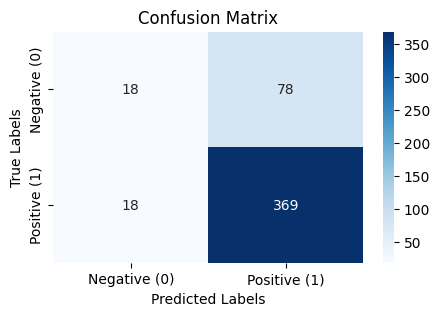

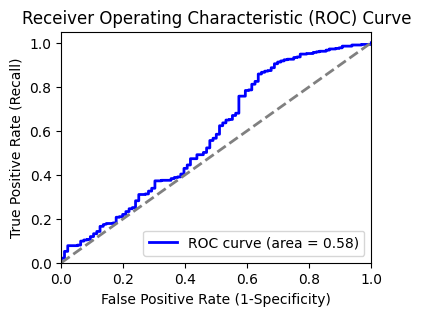

AUC: 0.58


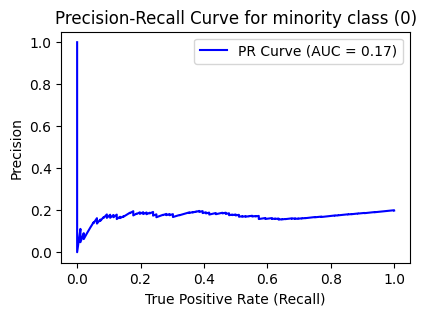

In [31]:
# # Initializing the performance evaluator class for RNN
rnn_performance_evaluator = ClassificationEvaluator(true_labels=rnn_y_test, 
                                                    predicted_labels=rnn_predictions_discrete, 
                                                    predicted_probs=rnn_predictions)

rnn_performance_evaluator.evaluate()
rnn_performance_evaluator.plot_confusion_matrix()
rnn_performance_evaluator.plot_roc_auc()
rnn_performance_evaluator.plot_precision_recall_auc()

#### RNN Classification Report Interpretation

1. Classification Report
- Mdodel's performance on class 1 (positive) is fairly good. However, all the three metrics, precision, recall and f1-score on class 0 need attention. This can be atrributed to the imbalance in the dataset with class 1 having more instances (387) than class 0 (96). The performance would have been better, if the model would have had more negative samples to learn from.

2. ROC_AUC Curve
- The AUC of 0.58 suggests that the model has limited ability to distinguish between the positive and negative classes. Its marginally better than random guessing.

3. PR Curve
- Low AUC (0.17) suggests poor model performance in distinguishing between the positive and negative classes for minority class.<br>
- Both precision and recall are low across different thresholds meaning a struggling model to identify minority class, resulting in may fasle positives and fasle negatives. Can be noticed in the confusion matrix.<br>

### 3.4. Hyperparameter tuning

In [108]:
def build_hypermodel(hp):
    model = Sequential()
    model.add(Input(shape=(max_sequence_length,)))
    model.add(Embedding(input_dim=vocab_size, 
                        output_dim=embedding_dim,
                        weights=[embedding_matrix],  
                        trainable=False))
    
    # Choose between LSTM and GRU
    rnn_type = hp.Choice('rnn_type', ['LSTM', 'GRU'])
    rnn_units = 64 #hp.Int('rnn_units', min_value=32, max_value=128, step=32)
    
    if rnn_type == 'LSTM':
        rnn_layer = LSTM(units=rnn_units, return_sequences=False, kernel_regularizer=l2(hp.Float('l2', 0.0, 0.1, step=0.01)))
    else:
        rnn_layer = GRU(units=rnn_units, return_sequences=False, kernel_regularizer=l2(hp.Float('l2', 0.0, 0.1, step=0.01)))
    
    # Add Bidirectional wrapper if specified
    if hp.Boolean('bidirectional'):
        model.add(Bidirectional(rnn_layer))
    else:
        model.add(rnn_layer)
    
    model.add(Dropout(rate=hp.Float('dropout', 0.1, 0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(hp.Float('l2_dense', 0.0, 0.1, step=0.01))))
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', 1e-5, 1e-3, sampling='log')),
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    return model


In [109]:
tuner = BayesianOptimization(
    build_hypermodel,
    objective='val_accuracy',
    max_trials=10,  
    executions_per_trial=1,  # Averages the results over multiple runs
    directory='bayesian_optimization',
    project_name='rnn_tuning'
)

Reloading Tuner from bayesian_optimization\rnn_tuning\tuner0.json


In [111]:
# Early stopping callback
hpt_early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# # Start the search
tuner.search(X_train, y_train,
             epochs=10,
             validation_data=(X_val, y_val),
             batch_size=32,
             callbacks=[hpt_early_stopping])


# # Get the best hyperparameters and model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]

# Print the best hyperparameters
print(f"Best RNN type: {best_hps.get('rnn_type')}")
print(f"Use bidirectional: {best_hps.get('bidirectional')}")
print(f"Best dropout rate: {best_hps.get('dropout')}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")

# Summary of the best model
best_model.summary()

Best RNN type: GRU
Use bidirectional: False
Best dropout rate: 0.2
Best learning rate: 2.5525782159678046e-05


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 50)         │       294,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        22,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 316,737 (1.21 MB)

 Trainable params: 22,337 (87.25 KB)

 Non-trainable params: 294,400 (1.12 MB)

In [101]:
# # In case if the tuning code throws Value error, then need to clear the old model states from the memory
# from tensorflow.keras import backend as K
# K.clear_session()

Only to display the output, I have ran 10 trials, but have performed a run of 100 trials. The learning rate, RNN type is derived from that run.

## 4. DistilBERT

### 4.1. Clean the tweets for DistilBERT

In [38]:
# Initialize the DataPreprocessor class for DistilBERT
dtb_train_datapreprocessor = DataPreprocessor(df=train_df, content_column='content')
dtb_test_datapreprocessor = DataPreprocessor(df=test_df, content_column='content')

In [ ]:
#! pip install accelerate
#! pip install transformers[torch]

In [39]:
dtb_train_df = dtb_train_datapreprocessor.preprocess(remove_spam=True, 
                                                     remove_hashtags=True, 
                                                     remove_emoji=True, 
                                                     remove_link=True, 
                                                     remove_whitespace_html=True)

dtb_test_df = dtb_test_datapreprocessor.preprocess(remove_spam=True, 
                                                   remove_hashtags=True, 
                                                   remove_emoji=True, 
                                                   remove_link=True, 
                                                   remove_whitespace_html=True)

c:\Users\Diya\Documents\GItHub\DELTA_Element3\Data_Preprocess.py:114: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  tweet = BeautifulSoup(tweet, 'html.parser').get_text()
c:\Users\Diya\Documents\GItHub\DELTA_Element3\Data_Preprocess.py:114: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  tweet = BeautifulSoup(tweet, 'html.parser').get_text()


In [40]:
i = 7
dtb_test_df['content'][i], dtb_test_df['cleaned_content'][i], dtb_test_df['sentiment'][i]

('#Hex launched &amp; gained 11,900%\n(Nomics .com)\n\n#Pulsechain 2 do- 3X of $HEX \n\nWhy?\n\n#PLS -Already has 40k user \n75-85k new Buyer\nOver 60 projects ready\n\nAlmost 80% supply be locked\nBy #OG #Staking #Validator \n\nRetweet ❤️ $PLS ppl\n\n#BTC #BNB #HEX #PLS #PLSX #ETH #Crypto #XRP #USDT https://t.co/ZG3OlPOyUy',
 'launched & gained 11,900% (Nomics .com) 2 do- 3X of $HEX Why? -Already has 40k user 75-85k new Buyer Over 60 projects ready Almost 80% supply be locked By Retweet  $PLS ppl #BTC #BNB X #ETH #Crypto #XRP #USDT',
 1)

In [41]:
dtb_test_df.head()

,content,username,sentiment,cleaned_content
0,#crypto $crypto #btc \nI am Chinese crypto alp...,huahuayjy,1,#crypto $crypto #btc I am Chinese crypto alpha...
1,#Bitcoin would have to fall another 80% to rea...,luke_broyles,0,#Bitcoin would have to fall another 80% to rea...
2,#Giveaway $1000 Matic in 3Days\n\n🏆To win\n1️⃣...,cryptomarsdo,1,#Giveaway $1000 Matic in 3Days To win keycap_...
3,Up or Down?\n\n!!! $EOS #EOS !!!\n\nVS\n\n$USD...,andreyukrnet,1,Up or Down? !!! $EOS !!! VS $USDT #USDT AND $B...
4,Mid Day Mix-up is LIVE! Never know who might s...,JustAman04,1,Mid Day Mix-up is LIVE! Never know who might s...


In [42]:
# Split the data to training and validation
dtb_X_train, dtb_X_val, dtb_y_train, dtb_y_val = train_test_split(dtb_train_df['cleaned_content'], dtb_train_df['sentiment'], test_size = 0.2, random_state = 9)
# Changing the dtype from series to array
dtb_y_train = dtb_y_train #.to_numpy()
dtb_y_val = dtb_y_val #.to_numpy()

# Preparing the test data
dtb_X_test = dtb_test_df['cleaned_content']
dtb_y_test = dtb_test_df['sentiment']

### 4.2. Predict with pre-trained and fine-tuned DistilBERT

The entire pipeline of generating predicitons using a pre-trained DistilBERT and then fine-tuned DistilBERT is implemented in a class 'DistilBERTSentimentAnalyzer' imported from 'DistilBERT.py'. Here is the detailed description of the approach.

#### **Pre-trained Analysis Pipeline:**

1. **Tokenization:**
   - 'pretrained_tokenizer' to tokenize and preprocess the input tweets.
   - Convert the tweets into a format suitable for the model. Padds and truncates the tweets to specified maximum length.

2. **Prediction:**
   - Pass the tokenized input to the 'pretrained_model'.
   - The model outputs logits, which represent the raw predictions.
   - 'torch.argmax' to convert the logits into predicted class labels.

3. **Evaluation:**
   - Evaluate the performance of the pre-trained model on the test data using the predicted labels.

**Function:**
- 'run_pretrained_analysis(analyzer, test_texts)'

#### **Fine-tuned Analysis Pipeline:**

1. **Tokenization:**
   - 'finetuned_tokenizer' to tokenize and preprocess the training, validation, and test tweets.
   - Prepares the data for training and evaluation.

2. **Prepare Labels:**
   - Convert the training and validation labels into tensors.

3. **Initial Training (with Frozen Layers):**
   - Freeze all layers of the 'finetuned_model' except for the output layer.
   - Set up training arguments using 'TrainingArguments'.
   - Define training and validation datasets.
   - Train the model using the 'Trainer' class, updating only the output layer initially.

4. **Gradual Unfreezing:**
   - Unfreeze all layers of the model to allow for further fine-tuning.
   - Continue training the model with all layers unfrozen to adjust pre-trained features for the specific task.

5. **Evaluation:**
   - Evaluate the fine-tuned model on the test data using the updated weights.

**Function:**
- 'run_finetuned_analysis(analyzer, train_texts, train_labels, val_texts, val_labels, test_texts)'

In [43]:
# Initialize the analyzer
analyzer = DistilBERTSentimentAnalyzer(
    pretrained_model_name='DT12the/distilbert-sentiment-analysis',
    finetuned_model_name='distilbert-base-uncased-finetuned-sst-2-english'
)

# Example usage with your data
pt_dtb_predictions = run_pretrained_analysis(analyzer, dtb_test_df['cleaned_content'].to_list())

# # Fine-tune and evaluate
ft_dtb_predictions = run_finetuned_analysis(
    analyzer,
    train_texts = dtb_X_train.to_list(),
    train_labels = dtb_y_train.values,
    val_texts = dtb_X_val.to_list(),
    val_labels = dtb_y_val.values,
    test_texts= dtb_X_test.to_list()
)

  0%|          | 0/72 [00:00<?, ?it/s]

c:\Users\Diya\Documents\GItHub\DELTA_Element3\DistilBERT.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
c:\Users\Diya\Documents\GItHub\DELTA_Element3\DistilBERT.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


{'train_runtime': 164.0326, 'train_samples_per_second': 7.011, 'train_steps_per_second': 0.439, 'train_loss': 0.4096068541208903, 'epoch': 1.0}


  0%|          | 0/72 [00:00<?, ?it/s]

{'train_runtime': 172.8606, 'train_samples_per_second': 6.653, 'train_steps_per_second': 0.417, 'train_loss': 0.18311840958065456, 'epoch': 1.0}


### 4.3. Classification report for pre-trained DistilBERT

Classification report:

              precision    recall  f1-score   support

           0       0.73      0.60      0.66        96
           1       0.91      0.95      0.93       387

    accuracy                           0.88       483
   macro avg       0.82      0.77      0.79       483
weighted avg       0.87      0.88      0.87       483



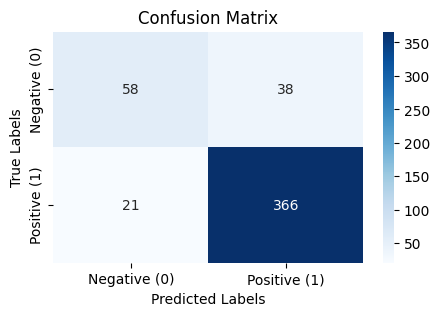

In [44]:
# The pre-trained DistilBERT maps positive class to 0 and negative class to 1, which is opposite of our labels. Hence flipped them
flipped_predictions = 1 - pt_dtb_predictions

# Initializing the performance evaluator class for pre-trained DistilBERT
pt_dtb_performance_evaluator = ClassificationEvaluator(true_labels=dtb_test_df['sentiment'].to_list(), 
                                                       predicted_labels=flipped_predictions)

pt_dtb_performance_evaluator.evaluate()
pt_dtb_performance_evaluator.plot_confusion_matrix()

### 4.4. Classification report for fine-tuned DistilBERT

Classification report:

              precision    recall  f1-score   support

           0       0.79      0.62      0.70        96
           1       0.91      0.96      0.93       387

    accuracy                           0.89       483
   macro avg       0.85      0.79      0.82       483
weighted avg       0.89      0.89      0.89       483



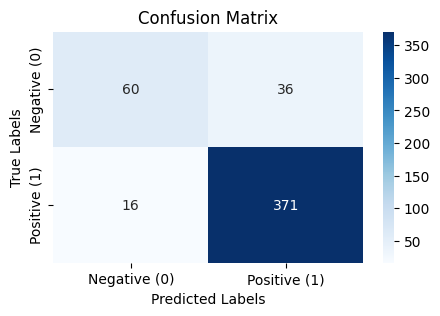

In [45]:
# Initializing the performance evaluator class for pre-trained DistilBERT
ft_dtb_performance_evaluator = ClassificationEvaluator(true_labels=dtb_test_df['sentiment'].to_list(), 
                                                       predicted_labels=ft_dtb_predictions)

ft_dtb_performance_evaluator.evaluate()
ft_dtb_performance_evaluator.plot_confusion_matrix()

## 5. Final Comparison

### 5.1. Code

In [60]:
from sklearn.metrics import classification_report

def get_classification_scores(true_labels, predicted_labels):
    report = classification_report(true_labels, predicted_labels, output_dict=True)
    # Extract the relevant scores
    scores = {
        'precision_0': report['0']['precision'],
        'recall_0': report['0']['recall'],
        'f1_score_0': report['0']['f1-score'],
        'precision_1': report['1']['precision'],
        'recall_1': report['1']['recall'],
        'f1_score_1': report['1']['f1-score'],
        'accuracy': report['accuracy']
    }
    return scores

model_predictions = {
    'vaderSentiment': vader_test_df['vader_sentiment_label'],
    'RNN (LSTM 64)': rnn_predictions_discrete, 
    'Pre-trained DistilBERT': flipped_predictions,
    'Fine-tuned DistilBERT': ft_dtb_predictions,  
}

# True labels
true_labels = dtb_test_df['sentiment'].to_list()

results = []

for model_name, predictions in model_predictions.items():
    scores = get_classification_scores(true_labels, predictions)
    scores['model'] = model_name
    results.append(scores)

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.set_index('model').map(lambda x: f"{x:.2f}")

### 5.2. Comparison Table and conclusion

In [61]:
results_df

,precision_0,recall_0,f1_score_0,precision_1,recall_1,f1_score_1,accuracy
model,,,,,,,
vaderSentiment,0.58,0.45,0.51,0.87,0.92,0.89,0.83
RNN (LSTM 64),0.48,0.24,0.32,0.83,0.94,0.88,0.80
Pre-trained DistilBERT,0.73,0.60,0.66,0.91,0.95,0.93,0.88
Fine-tuned DistilBERT,0.79,0.62,0.70,0.91,0.96,0.93,0.89


- The table compares the classification performane of all 4 models tracking their precision, recall and F1 score for both the classes.
- From the numbers, **Fine-tuned DistilBERT** is the best overall, consistently giving high scores in precision, recall, and F1 score for both categories. It outperforms other models, particularly the minority class, which is crucial in this imbalanced dataset.
- Having said that, it is worth to note the performance of our benchmark model i.e. VaderSentiment. Although comparatively simpler, it outperforms RNN in every other metric (optimistically thinking that I have fitted the best possible RNN).
- I have noticed improved performance every model as I refined my data preprocessing, after learning from every iteration. Hence I will attribute a large share of improved performance to data preprocessing and I believe that there still sope for improvement.